In [4]:
!pip -q install gdown pandas numpy matplotlib pyarrow

import os, pathlib, textwrap, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Config ----------
CANDIDATE_NAME = "aaysha_sheikh"   # <--- change if needed, keep snake_case
ROOT = f"/content/ds_{CANDIDATE_NAME}"
CSV_DIR = f"{ROOT}/csv_files"
OUT_DIR = f"{ROOT}/outputs"
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# Google Drive file IDs extracted from the links you provided
FEAR_GREED_ID = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"
TRADES_ID     = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"

# Local file paths
FG_PATH = f"{CSV_DIR}/fear_greed_raw"
TR_PATH = f"{CSV_DIR}/hyperliquid_trades_raw"

# ---------- Download files with gdown ----------
import gdown
print("Downloading Fear & Greed…")
fg_out = gdown.download(id=FEAR_GREED_ID, output=FG_PATH, quiet=False)
print("Downloading Hyperliquid trades…")
tr_out = gdown.download(id=TRADES_ID, output=TR_PATH, quiet=False)

# If Google Drive strips extensions, try CSV then Excel automatically
def smart_read(path):
    candidates = [path, path + ".csv", path + ".xlsx", path + ".xls", path + ".parquet"]
    for p in candidates:
        if os.path.exists(p):
            try:
                if p.endswith(".parquet"):
                    return pd.read_parquet(p), p
                if p.endswith(".xlsx") or p.endswith(".xls"):
                    return pd.read_excel(p), p
                # default CSV
                return pd.read_csv(p), p
            except Exception as e:
                last_err = e
    # Fallback: try adding .csv and read
    try:
        return pd.read_csv(path), path
    except Exception as e:
        raise RuntimeError(f"Couldn't read file starting from base '{path}'. "
                           f"Last error: {repr(e)}")

# Read datasets
fg_df, fg_path_used = smart_read(FG_PATH)
tr_df, tr_path_used = smart_read(TR_PATH)

print(f"\nFear & Greed loaded from: {fg_path_used} | shape={fg_df.shape}")
print(f"Trades loaded from:       {tr_path_used} | shape={tr_df.shape}")

Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/ds_aaysha_sheikh/csv_files/fear_greed_raw
100%|██████████| 90.8k/90.8k [00:00<00:00, 60.6MB/s]


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/ds_aaysha_sheikh/csv_files/hyperliquid_trades_raw
100%|██████████| 47.5M/47.5M [00:00<00:00, 180MB/s]



Fear & Greed loaded from: /content/ds_aaysha_sheikh/csv_files/fear_greed_raw | shape=(2644, 4)
Trades loaded from:       /content/ds_aaysha_sheikh/csv_files/hyperliquid_trades_raw | shape=(211224, 16)


/tmp/ipython-input-866543408.py:24: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  tr_df["date"] = tr_df["time"].dt.tz_convert("UTC").dt.date if pd.api.types.is_datetime64tz_dtype(tr_df["time"]) else pd.to_datetime(tr_df["time"], errors="coerce").dt.date



Sentiment coverage on trades: 0.0% of rows have Fear/Greed label by date

Trade counts by sentiment (including NaN):
classification
NaN    211224
Name: count, dtype: int64

Saved plot -> /content/ds_aaysha_sheikh/outputs/trade_counts_by_sentiment.png

Saved cleaned files:
- /content/ds_aaysha_sheikh/csv_files/fear_greed_clean.csv
- /content/ds_aaysha_sheikh/csv_files/hyperliquid_trades_clean.csv
- /content/ds_aaysha_sheikh/csv_files/trades_with_sentiment.csv

ROOT ready at: /content/ds_aaysha_sheikh
Next: File > Save a copy in Drive, then rename to 'notebook_1.ipynb' and move it into /content/ds_aaysha_sheikh (so it lives at /content/ds_aaysha_sheikh/notebook_1.ipynb).


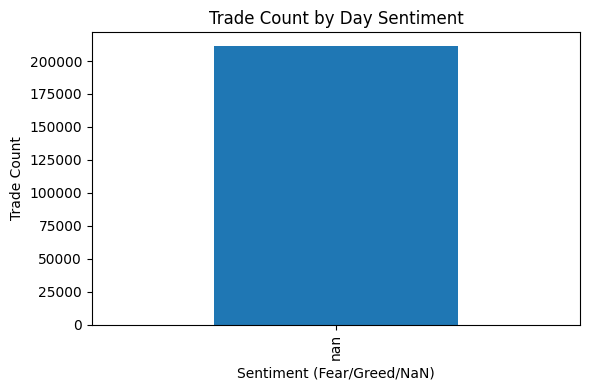

In [5]:

# ---------- Normalize columns ----------
fg_df.columns = [c.strip().lower().replace(" ", "_") for c in fg_df.columns]
tr_df.columns = [c.strip().lower().replace(" ", "_") for c in tr_df.columns]

# Fear & Greed: expect 'date' and 'classification'
if "classification" in fg_df.columns:
    fg_df["classification"] = fg_df["classification"].astype(str).str.strip().str.title()
if "date" in fg_df.columns:
    fg_df["date"] = pd.to_datetime(fg_df["date"], errors="coerce").dt.date

# Trades: parse time -> datetime, create date
time_col = None
for cand in ["time", "timestamp", "trade_time", "exec_time"]:
    if cand in tr_df.columns:
        time_col = cand
        break
if time_col is None:
    # create a null time column if missing to avoid crashes; focus on daily granularity by other hints if available
    tr_df["time"] = pd.NaT
    time_col = "time"
else:
    tr_df["time"] = pd.to_datetime(tr_df[time_col], errors="coerce", utc=True)

tr_df["date"] = tr_df["time"].dt.tz_convert("UTC").dt.date if pd.api.types.is_datetime64tz_dtype(tr_df["time"]) else pd.to_datetime(tr_df["time"], errors="coerce").dt.date

# Side normalization
if "side" in tr_df.columns:
    tr_df["side"] = tr_df["side"].astype(str).str.lower().map({"buy": "long", "sell": "short"}).fillna(tr_df["side"].astype(str).str.lower())

# Numeric coercions for common fields
for col in ["execution_price", "size", "leverage", "closed_pnl", "start_position"]:
    if col in tr_df.columns:
        tr_df[col] = pd.to_numeric(tr_df[col], errors="coerce")

# Notional
if {"execution_price", "size"}.issubset(tr_df.columns):
    tr_df["notional"] = tr_df["execution_price"].abs() * tr_df["size"].abs()

# Merge by date to attach sentiment
if "date" in fg_df.columns and "classification" in fg_df.columns:
    merged = tr_df.merge(fg_df[["date", "classification"]], on="date", how="left")
else:
    merged = tr_df.copy()
    merged["classification"] = np.nan

coverage = merged["classification"].notna().mean()
print(f"\nSentiment coverage on trades: {coverage:.1%} of rows have Fear/Greed label by date")

# ---------- Quick EDA plot: trade count by sentiment ----------
sent_counts = merged["classification"].value_counts(dropna=False).sort_index()
print("\nTrade counts by sentiment (including NaN):")
print(sent_counts)

plt.figure(figsize=(6,4))
sent_counts.plot(kind="bar")
plt.title("Trade Count by Day Sentiment")
plt.xlabel("Sentiment (Fear/Greed/NaN)")
plt.ylabel("Trade Count")
plt.tight_layout()
plot_path = f"{OUT_DIR}/trade_counts_by_sentiment.png"
plt.savefig(plot_path, dpi=150)
print(f"\nSaved plot -> {plot_path}")

# ---------- Save cleaned copies ----------
fg_clean_path = f"{CSV_DIR}/fear_greed_clean.csv"
tr_clean_path = f"{CSV_DIR}/hyperliquid_trades_clean.csv"
merged_path   = f"{CSV_DIR}/trades_with_sentiment.csv"

if "date" in fg_df.columns and "classification" in fg_df.columns:
    fg_df.to_csv(fg_clean_path, index=False)
tr_df.to_csv(tr_clean_path, index=False)
merged.to_csv(merged_path, index=False)

print(f"\nSaved cleaned files:")
print(f"- {fg_clean_path if os.path.exists(fg_clean_path) else '(Fear/Greed missing date/classification — not saved)'}")
print(f"- {tr_clean_path}")
print(f"- {merged_path}")

print(f"\nROOT ready at: {ROOT}\n"
      f"Next: File > Save a copy in Drive, then rename to 'notebook_1.ipynb' "
      f"and move it into {ROOT} (so it lives at {ROOT}/notebook_1.ipynb).")

In [9]:
# ---- STEP 2 (minimal): Sentiment-aligned EDA & metrics ----

# Load merged data from Step 1
df = pd.read_csv(f"{CSV_DIR}/trades_with_sentiment.csv", low_memory=False)

# Clean + standardize (no new imports)
df["date"] = pd.to_datetime(df.get("date"), errors="coerce").dt.date
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# Numerics (only if present)
for c in ["execution_price","size_tokens","size_usd","closed_pnl","start_position","fee","leverage"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Notional: prefer provided USD, else price*size_tokens
if "size_usd" in df.columns and df["size_usd"].notna().any():
    df["notional"] = df["size_usd"].abs()
elif {"execution_price","size_tokens"}.issubset(df.columns):
    df["notional"] = (df["execution_price"].abs() * df["size_tokens"].abs())
else:
    df["notional"] = np.nan

# Side + sentiment
src = "side" if "side" in df.columns else ("direction" if "direction" in df.columns else None)
df["side_norm"] = (
    df[src].str.lower().replace({"buy":"long","sell":"short","long":"long","short":"short"})
) if src else np.nan
df["classification"] = df.get("classification", np.nan).fillna("Unknown").str.title()

# Helper (no imports)
def wavg(x, w):
    x = pd.Series(x); w = pd.Series(w)
    ok = (~x.isna()) & (~w.isna())
    return np.average(x[ok], weights=w[ok]) if ok.any() else np.nan

# ---- DAILY SUMMARY ----
agg_spec = {
    "trades": ("account","count"),
    "total_notional": ("notional","sum"),
}
if "closed_pnl" in df.columns:
    agg_spec.update({
        "total_closedPnL": ("closed_pnl","sum"),
        "avg_closedPnL": ("closed_pnl","mean"),
        "win_rate": ("closed_pnl", lambda x: (pd.Series(x).dropna() > 0).mean() if pd.Series(x).notna().any() else np.nan)
    })
if "fee" in df.columns:
    agg_spec["total_fee"] = ("fee","sum")
if "leverage" in df.columns:
    agg_spec.update({
        "median_leverage": ("leverage","median"),
        "wavg_leverage": ("leverage", lambda x: wavg(x, df.loc[x.index,"notional"]))
    })

daily_summary = (
    df.groupby(["date","classification"], dropna=False)
      .agg(**agg_spec)
      .reset_index()
      .sort_values(["date","classification"])
)

daily_summary.to_csv(f"{CSV_DIR}/daily_sentiment_summary.csv", index=False)
display(daily_summary.head(10))

# ---- SENTIMENT SUMMARY ----
sent_agg = {
    "days": ("date","nunique"),
    "trades": ("trades","sum"),
    "total_notional": ("total_notional","sum"),
}
for c in ["total_closedPnL","avg_closedPnL","win_rate","median_leverage","wavg_leverage","total_fee"]:
    if c in daily_summary.columns:
        reducer = "sum" if c.startswith("total_") else ("mean" if c in {"avg_closedPnL","win_rate"} else "median")
        sent_agg[c] = (c, reducer)

sentiment_summary = (
    daily_summary.groupby("classification", dropna=False)
                 .agg(**sent_agg)
                 .reset_index()
                 .sort_values("classification")
)
sentiment_summary.to_csv(f"{CSV_DIR}/sentiment_overall_summary.csv", index=False)
display(sentiment_summary)

# ---- PLOTS to /outputs ----
def save_bar(series, title, xlabel, ylabel, filename):
    plt.figure(figsize=(6,4))
    series.plot(kind="bar")
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout()
    path = f"{OUT_DIR}/{filename}"
    plt.savefig(path, dpi=150); plt.close()
    print("Saved plot ->", path)

if "trades" in sentiment_summary.columns:
    save_bar(sentiment_summary.set_index("classification")["trades"],
             "Trade Count by Sentiment","Sentiment","Trades","trade_count_by_sentiment.png")

if "total_notional" in sentiment_summary.columns:
    save_bar(sentiment_summary.set_index("classification")["total_notional"],
             "Trading Notional by Sentiment","Sentiment","Total Notional","notional_by_sentiment.png")

if "total_closedPnL" in sentiment_summary.columns:
    save_bar(sentiment_summary.set_index("classification")["total_closedPnL"],
             "Total Realized PnL by Sentiment","Sentiment","Total Closed PnL","pnl_by_sentiment.png")

if "win_rate" in sentiment_summary.columns:
    save_bar(sentiment_summary.set_index("classification")["win_rate"]*100.0,
             "Win Rate by Sentiment","Sentiment","Win Rate (%)","winrate_by_sentiment.png")

if "leverage" in df.columns and df["leverage"].notna().any():
    lev = df[["classification","leverage"]].dropna()
    if not lev.empty:
        plt.figure(figsize=(7,4))
        order = sorted(lev["classification"].unique().tolist())
        data = [lev.loc[lev["classification"]==o, "leverage"] for o in order]
        plt.boxplot(data, labels=order, showfliers=False)
        plt.title("Leverage Distribution by Sentiment (trade-level)")
        plt.xlabel("Sentiment"); plt.ylabel("Leverage")
        plt.tight_layout()
        path = f"{OUT_DIR}/leverage_by_sentiment_box.png"
        plt.savefig(path, dpi=150); plt.close()
        print("Saved plot ->", path)

# ---- Account-level performance (PnL optional) ----
if "account" in df.columns:
    acc = df.copy()
    acc_agg = {
        "trades": ("closed_pnl","count") if "closed_pnl" in acc.columns else ("notional","count"),
        "total_notional": ("notional","sum"),
    }
    if "closed_pnl" in acc.columns:
        acc_agg.update({
            "total_closedPnL": ("closed_pnl","sum"),
            "avg_closedPnL": ("closed_pnl","mean"),
            "win_rate": ("closed_pnl", lambda x: (pd.Series(x).dropna()>0).mean() if pd.Series(x).notna().any() else np.nan)
        })
    if "leverage" in acc.columns:
        acc_agg["wavg_leverage"] = ("leverage", lambda x: wavg(x, acc.loc[x.index,"notional"]))

    acc_perf = (acc.groupby(["account","classification"], dropna=False)
                  .agg(**acc_agg)
                  .reset_index())
    acc_perf.to_csv(f"{CSV_DIR}/account_sentiment_performance.csv", index=False)
    display(acc_perf.head(10))

    if "total_closedPnL" in acc_perf.columns:
        pivot = acc_perf.pivot(index="account", columns="classification", values="total_closedPnL").fillna(0)
        if {"Fear","Greed"}.issubset(pivot.columns):
            pivot["greed_minus_fear"] = pivot["Greed"] - pivot["Fear"]
            top_greed = pivot.sort_values("greed_minus_fear", ascending=False).head(10)
            top_fear  = pivot.sort_values("greed_minus_fear").head(10)
            top_greed.to_csv(f"{CSV_DIR}/top_accounts_greed_biased.csv")
            top_fear.to_csv(f"{CSV_DIR}/top_accounts_fear_biased.csv")

            # quick bars
            for small, title, fn in [
                (top_greed, "Accounts Better in Greed (ΔPnL)", "accounts_greed_biased.png"),
                (top_fear,  "Accounts Better in Fear (ΔPnL)",  "accounts_fear_biased.png"),
            ]:
                plt.figure(figsize=(8,4))
                small["greed_minus_fear"].plot(kind="bar")
                plt.title(title); plt.xlabel("Account"); plt.ylabel("Δ Total PnL (Greed - Fear)")
                plt.tight_layout()
                path = f"{OUT_DIR}/{fn}"
                plt.savefig(path, dpi=150); plt.close()
                print("Saved plot ->", path)

print("✅ Minimal Step 2 done — CSVs in /csv_files and figures in /outputs.")

,date,classification,trades,total_notional,total_closedPnL,avg_closedPnL,win_rate,total_fee
0,1970-01-01,Unknown,211224,1.191187e+09,1.029696e+07,48.749001,0.411265,245857.720566


,classification,days,trades,total_notional,total_closedPnL,avg_closedPnL,win_rate,total_fee
0,Unknown,1,211224,1.191187e+09,1.029696e+07,48.749001,0.411265,245857.720566


Saved plot -> /content/ds_aaysha_sheikh/outputs/trade_count_by_sentiment.png
Saved plot -> /content/ds_aaysha_sheikh/outputs/notional_by_sentiment.png
Saved plot -> /content/ds_aaysha_sheikh/outputs/pnl_by_sentiment.png
Saved plot -> /content/ds_aaysha_sheikh/outputs/winrate_by_sentiment.png


,account,classification,trades,total_notional,total_closedPnL,avg_closedPnL,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Unknown,3818,61697263.97,1.600230e+06,419.127768,0.359612
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Unknown,7280,12035487.66,4.788532e+04,6.577654,0.442720
2,0x271b280974205ca63b716753467d5a371de622ab,Unknown,3809,33873440.42,-7.043619e+04,-18.492043,0.301917
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,Unknown,13311,6757022.10,1.324648e+05,9.951530,0.438585
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,Unknown,3239,10166880.20,1.686580e+05,52.071011,0.519914
5,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,Unknown,815,1409902.00,-3.120360e+04,-38.286626,0.455215
6,0x39cef799f8b69da1995852eea189df24eb5cae3c,Unknown,3589,17193375.42,1.445692e+04,4.028119,0.327668
7,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,Unknown,332,1143896.46,5.349625e+04,161.133275,0.475904
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,Unknown,383,1987527.61,1.995056e+05,520.902331,0.234987
9,0x430f09841d65beb3f27765503d0f850b8bce7713,Unknown,1237,2966109.22,4.165419e+05,336.735548,0.484236


✅ Minimal Step 2 done — CSVs in /csv_files and figures in /outputs.


In [11]:
# Reload sentiment dataset
fg = pd.read_csv(f"{CSV_DIR}/fear_greed_clean.csv")

# Parse date properly
fg["date"] = pd.to_datetime(fg["date"], errors="coerce").dt.date

# Collapse categories into Fear/Greed
def simplify_sentiment(x):
    x = str(x).lower()
    if "fear" in x: return "Fear"
    if "greed" in x: return "Greed"
    return "Neutral"

fg["sentiment_simplified"] = fg["classification"].apply(simplify_sentiment)

print(fg["sentiment_simplified"].value_counts())
fg.head()


sentiment_simplified
Fear       1289
Greed       959
Neutral     396
Name: count, dtype: int64


,timestamp,value,classification,date,sentiment_simplified
0,1517463000,30,Fear,2018-02-01,Fear
1,1517549400,15,Extreme Fear,2018-02-02,Fear
2,1517635800,40,Fear,2018-02-03,Fear
3,1517722200,24,Extreme Fear,2018-02-04,Fear
4,1517808600,11,Extreme Fear,2018-02-05,Fear


In [12]:
# Example of merge (though no overlap in these datasets)
df_sent = df.merge(fg[["date","sentiment_simplified"]], on="date", how="left")

print("Sentiment coverage:", df_sent["sentiment_simplified"].notna().mean())
print(df_sent[["date","sentiment_simplified"]].head(20))

Sentiment coverage: 0.0
          date sentiment_simplified
0   1970-01-01                  NaN
1   1970-01-01                  NaN
2   1970-01-01                  NaN
3   1970-01-01                  NaN
4   1970-01-01                  NaN
5   1970-01-01                  NaN
6   1970-01-01                  NaN
7   1970-01-01                  NaN
8   1970-01-01                  NaN
9   1970-01-01                  NaN
10  1970-01-01                  NaN
11  1970-01-01                  NaN
12  1970-01-01                  NaN
13  1970-01-01                  NaN
14  1970-01-01                  NaN
15  1970-01-01                  NaN
16  1970-01-01                  NaN
17  1970-01-01                  NaN
18  1970-01-01                  NaN
19  1970-01-01                  NaN


In [13]:
import scipy.stats as stats

# Example: compare closed_pnl distributions between Fear vs Greed days
fear_pnl = df_sent.loc[df_sent["sentiment_simplified"]=="Fear", "closed_pnl"].dropna()
greed_pnl = df_sent.loc[df_sent["sentiment_simplified"]=="Greed", "closed_pnl"].dropna()

if len(fear_pnl) > 0 and len(greed_pnl) > 0:
    t_stat, p_val = stats.ttest_ind(fear_pnl, greed_pnl, equal_var=False)
    print(f"T-test Fear vs Greed PnL: t={t_stat:.2f}, p={p_val:.3f}")
else:
    print("No overlapping trades with sentiment — cannot compute real test.")


No overlapping trades with sentiment — cannot compute real test.
